In [223]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

Read the data.  I am turning off the na filter because there are a lot of "legitimate" NA values in the data, i.e., the "NA" value often has real meaning.  This approach will lead to a little more work cleaning but, hopefully, retain more information in the data.

In [358]:
# This reads "legitimate" values of NA as null
df_train = pd.read_csv('train.csv', header=0, na_filter=False)
df_test = pd.read_csv('test.csv', header=0, na_filter=False)
y = df_train.pop('SalePrice')
df_train['TrainTest'] = 'Train'
df_test['TrainTest'] = 'Test'
df = pd.concat([df_train,df_test], ignore_index=True)

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2919 non-null object
LotFrontage      2919 non-null object
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-

# Data Prep

One downside to turning off the na filter is that any numeric feature becomes an `object` feature if there are any missing values.  Let's fix this first.

In [360]:
df['LotFrontage'] = df['LotFrontage'].replace('NA',np.nan).apply(float)
df['MasVnrArea'] = df['MasVnrArea'].replace('NA',np.nan).apply(float)
df['BsmtFinSF1'] = df['BsmtFinSF1'].replace('NA',np.nan).apply(float)
df['BsmtFinSF2'] = df['BsmtFinSF2'].replace('NA',np.nan).apply(float)
df['BsmtUnfSF'] = df['BsmtUnfSF'].replace('NA',np.nan).apply(float)
df['TotalBsmtSF'] = df['TotalBsmtSF'].replace('NA',np.nan).apply(float)
df['BsmtFullBath'] = df['BsmtFullBath'].replace('NA',np.nan).apply(float)
df['BsmtHalfBath'] = df['BsmtHalfBath'].replace('NA',np.nan).apply(float)
df['GarageYrBlt'] = df['GarageYrBlt'].replace('NA',np.nan).apply(float)
df['GarageArea'] = df['GarageArea'].replace('NA',np.nan).apply(float)
df['GarageCars'] = df['GarageCars'].replace('NA',np.nan).apply(float)

The `MSSubClass` data was interpreted as `int` but it is really categorical, so make it `str` instead.

In [361]:
df['MSSubClass'] = df['MSSubClass'].apply(str)

Now let's find the "legitimate" NA values and call them something else: `None` works.  Any other NA values left are the real missing data.

In [362]:
df['Alley'].replace('NA','None', inplace=True)
df['BsmtQual'].replace('NA','None', inplace=True)
df['BsmtCond'].replace('NA','None', inplace=True)
df['BsmtExposure'].replace('NA','None', inplace=True)
df['BsmtFinType1'].replace('NA','None', inplace=True)
df['BsmtFinType2'].replace('NA','None', inplace=True)
df['FireplaceQu'].replace('NA','None', inplace=True)
df['GarageType'].replace('NA','None', inplace=True)
df['GarageFinish'].replace('NA','None', inplace=True)
df['GarageQual'].replace('NA','None', inplace=True)
df['GarageCond'].replace('NA','None', inplace=True)
df['PoolQC'].replace('NA','None', inplace=True)
df['Fence'].replace('NA','None', inplace=True)
df['MiscFeature'].replace('NA','None', inplace=True)

df.replace('NA',np.nan, inplace=True)

Several of the categorical features are actually ranking the quality of some element of the home.  This will be replaced by an integer ranking system.

In [363]:
qual_to_num = {'Ex':5, 
               'Gd':4,
               'TA':3,
               'Fa':2,
               'Po':1,
               'None':0}
df['ExterQual']  = df['ExterQual'].map(qual_to_num)
df['ExterCond']  = df['ExterCond'].map(qual_to_num)
df['BsmtQual']   = df['BsmtQual'].map(qual_to_num)
df['BsmtCond']   = df['BsmtCond'].map(qual_to_num)
df['HeatingQC']  = df['HeatingQC'].map(qual_to_num)
df['KitchenQual'] = df['KitchenQual'].map(qual_to_num)
df['FireplaceQu'] = df['FireplaceQu'].map(qual_to_num)
df['GarageQual']  = df['GarageQual'].map(qual_to_num)
df['GarageCond']  = df['GarageCond'].map(qual_to_num)
df['PoolQC']      = df['PoolQC'].map(qual_to_num)

BsmtExposure_to_num = {'Gd':4,
                       'Av':3,
                       'Mn':2,
                       'No':1,
                       'None':0}
df['BsmtExposure'] = df['BsmtExposure'].map(BsmtExposure_to_num)

BsmtFinType1_to_num = {'GLQ':6,
                       'ALQ':5,
                       'BLQ':4,
                       'Rec':3,
                       'LwQ':2,
                       'Unf':1,
                       'None':0}
df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFinType1_to_num)
df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFinType1_to_num)

Functional_to_num = {'Typ':8,
                     'Min1':7,
                     'Min2':6,
                     'Mod':5,
                     'Maj1':4,
                     'Maj2':3,
                     'Sev':2,
                     'Sal':1}
df['Functional'] = df['Functional'].map(Functional_to_num)
GarageFinish_to_num = {'Fin':3,
                       'RFn':2,
                       'Unf':1,
                       'None':0}
df['GarageFinish'] = df['GarageFinish'].map(GarageFinish_to_num)

Some missing values could indicate the lack of the feature in the first place.  For example, if there is no basement, basement square footage is irrelevant.

In [364]:
no_bsmt = df['BsmtQual'] == 0
df.loc[no_bsmt,['BsmtQual',
                'BsmtCond',
                'BsmtExposure',
                'BsmtFinType1',
                'BsmtFinSF1',
                'BsmtFinType2',
                'BsmtFinSF2',
                'BsmtUnfSF',
                'TotalBsmtSF',
                'BsmtFullBath',
                'BsmtHalfBath']] = 0

In [365]:
no_fireplace = df['Fireplaces']==0
df.loc[no_fireplace,'FireplaceQu']=0

In [366]:
no_garage = df['GarageType'] == 'None'
df.loc[no_garage,['GarageType',
                  'GarageYrBlt',
                  'GarageFinish',
                  'GarageCars',
                  'GarageArea',
                  'GarageQual',
                  'GarageCond',]] = 0

In [367]:
no_pool = (df['PoolQC']==0) | (df['PoolArea']==0)
df.loc[no_pool,['PoolArea','PoolQC']] = 0

In [368]:
no_masonry = df['MasVnrArea'].isnull()
df.loc[no_masonry,'MasVnrArea'] = 0

no_masonry = df['MasVnrArea']==0
df.loc[no_masonry,'MasVnrType'] = 'None'

What is included in `MiscFeature`?

In [380]:
df.loc[df['MiscFeature'] != 'None','MiscFeature'].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

Most of this is clearly revealing whether some properties have sheds.  The 10 objects not included do not represent much data (and "Othr" should have no predictive quality... pool? rock garden? scenic overlook?), so let's just drop this feature altogether.

In [381]:
df.drop('MiscFeature', axis=1, inplace=True)

What missing data is left?

In [382]:
for feat in df:
    cnt = df[feat].isnull().sum()
    if cnt>0:
        print feat, cnt

MSZoning 4
LotFrontage 486
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 1
Electrical 1
KitchenQual 1
Functional 2
GarageYrBlt 2
GarageCars 1
GarageArea 1
SaleType 1


I am going to fill in missing data by populating it with the mean (numeric) or mode (categorical) corresponding to `MSZoning`.

In [383]:
grouped = df.groupby('MSZoning')

# Define the aggregation
def f(x): 
    if x.dtype in ['int','float']:
        return np.mean(x)
    else :
        m = x.mode()
        return m[0] if len(m) > 0 else np.nan

# Apply the aggregation function then check for an null values
g = grouped.aggregate(f)
for col in g:
    if g[col].isnull().any(): print g[col]
        
# Look at the result
g

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TrainTest
MSZoning,,,,,,,,,,,,,,,,,,,,,
C (all),1625.680000,30,65.608696,8320.720000,Pave,None,Reg,Lvl,AllPub,Inside,...,3.960000,0.000000,0.00000,None,24.560000,7.320000,2007.960000,WD,Normal,Test
FV,1416.870504,160,59.529412,6549.359712,Pave,None,Reg,Lvl,AllPub,Inside,...,6.776978,0.000000,0.00000,None,0.000000,6.266187,2007.949640,WD,Normal,Test
RH,1281.615385,120,55.434783,7506.461538,Pave,None,Reg,Lvl,AllPub,Inside,...,4.615385,0.000000,0.00000,None,19.230769,7.076923,2007.884615,WD,Normal,Train
RL,1453.954084,20,74.052202,11169.471965,Pave,None,Reg,Lvl,AllPub,Inside,...,17.982781,2.295806,0.01766,None,58.731567,6.224283,2007.780574,WD,Normal,Train
RM,1496.382609,50,52.246479,6400.239130,Pave,None,Reg,Lvl,AllPub,Inside,...,10.856522,0.000000,0.00000,None,30.913043,6.063043,2007.791304,WD,Normal,Test


Not all properties are zoned (or at least have zoning data).  Backfill with the mode, which is `RL`.

In [384]:
df['MSZoning'].fillna(df['MSZoning'].mode()[0],inplace=True)

Now populate all the missing data by zone.

In [385]:
for zone in g.index:
    zoning_subset = df['MSZoning']==zone
    df[zoning_subset] = df[zoning_subset].fillna(g.loc[zone,:])

All of the missing values should be gone, but let's verify.

In [386]:
df.isnull().any().any()

False

# Feature Selection

In [387]:
training_set = df['TrainTest']=='Train'
test_set = df['TrainTest']=='Test'

X = df.drop('TrainTest',axis=1)
df_train = X[training_set].copy()
df_test = X[test_set].copy()

num_feats = df_train.dtypes[df_train.dtypes != "object"].index
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index

In [388]:
df_train[num_feats].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
LotFrontage,1460.0,70.358340,22.195728,21.0,60.00,72.5,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
ExterQual,1460.0,3.395890,0.574280,2.0,3.00,3.0,4.00,5.0
ExterCond,1460.0,3.083562,0.351054,1.0,3.00,3.0,3.00,5.0


In [389]:
df_train[cat_feats].describe().transpose()

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,None,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


# Model Creation

In [390]:
X = pd.get_dummies(df.drop('TrainTest',axis=1))
df_train = X[training_set].copy()
df_test = X[test_set].copy()
y0 = y

In [391]:
y = np.log(y0)

In [392]:
print df[training_set].shape
print X.shape

(1460, 80)
(2919, 248)


In [393]:
x_train = StandardScaler().fit_transform(df_train)
alphas = np.logspace(-3,-2,20)
cvs = []
for alpha in alphas:
    linreg_l1 = Lasso(alpha=alpha,normalize=False)
    cv = cross_validation.cross_val_score(linreg_l1, x_train, y, cv=5, scoring='mean_squared_error')
    cvs.append(np.mean(np.sqrt(np.abs(cv))))

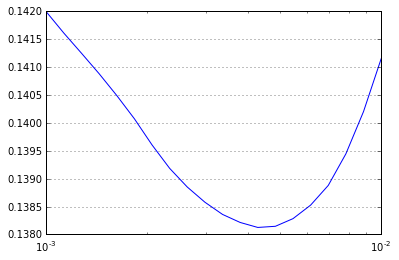

In [394]:
fig, ax = plt.subplots()
ax.semilogx(alphas,cvs)
ax.grid(True)

In [395]:
alpha = 0.003
linreg_l1 = Lasso(alpha=alpha)
linreg_l1 = linreg_l1.fit(x_train, y)
output = linreg_l1.predict(x_train)
cv = cross_validation.cross_val_score(linreg_l1, x_train, y, cv=5, scoring='mean_squared_error')

print 'Prediction accuracy = ', np.sqrt(mean_squared_error(y,output))
print '5-Fold cross validation = ', np.mean(np.sqrt(np.abs(cv)))

Prediction accuracy =  0.103166642934
5-Fold cross validation =  0.138561536996


In [295]:
x_test = StandardScaler().fit_transform(df_test)
output = np.exp(linreg_l1.predict(x_test))
with open('output.csv','wb') as csv_file :
    output_file = csv.writer(csv_file)
    output_file.writerow(["Id", "SalePrice"])
    for pid,s in zip(df_test['Id'],output) :       # For each row in test.csv
        output_file.writerow([pid,int(s)])